In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import tifffile as tif
import os

from cloudvolume import CloudVolume

from skimage.transform import rotate

%matplotlib inline

In [2]:
def get_coord(l):
    
    n = len(l)
    coord = np.zeros((n,3))
    for i in range(n):
        c_str = l[i]
        elem = c_str[1:-1].split(",")
        coord[i,0] = int(elem[0])
        coord[i,1] = int(elem[1])
        coord[i,2] = int(elem[2])
        
    return coord

## Import landmark coordinates

In [3]:
center_df = pd.read_csv("center.csv")
corner_df = pd.read_csv("corner.csv")
center_df

,Coordinate 1,Coordinate 2,Ellipsoid Dimensions,Tags,Description,Segment IDs,Parent ID,Type,ID
0,"(13163, 12460, 0)",NaN,NaN,NaN,NaN,NaN,NaN,Point,NaN
1,"(14135, 15514, 1)",NaN,NaN,NaN,NaN,NaN,NaN,Point,NaN
2,"(12471, 13040, 2)",NaN,NaN,NaN,NaN,NaN,NaN,Point,NaN
3,"(12543, 13719, 3)",NaN,NaN,NaN,NaN,NaN,NaN,Point,NaN
4,"(13463, 14372, 4)",NaN,NaN,NaN,NaN,NaN,NaN,Point,NaN
...,...,...,...,...,...,...,...,...,...
718,"(11487, 10885, 718)",NaN,NaN,NaN,NaN,NaN,NaN,Point,NaN
719,"(12363, 10392, 719)",NaN,NaN,NaN,NaN,NaN,NaN,Point,NaN
720,"(12490, 11115, 720)",NaN,NaN,NaN,NaN,NaN,NaN,Point,NaN
721,"(12958, 10868, 721)",NaN,NaN,NaN,NaN,NaN,NaN,Point,NaN


In [4]:
ct_p = get_coord(center_df["Coordinate 1"])
cn_p = get_coord(corner_df["Coordinate 1"])

## Download downsampled sections

In [5]:
vol = CloudVolume("gs://zetta_jkim_001_drop/celegans_montage_unaligned", mip=4, parallel=True, progress=False)

In [7]:
output_d = "/Users/jabae/Documents/celegans_mip4"

i = 58
img = vol[:,:,i][:,:,0,0]
tif.imwrite(os.path.join(output_d, "z_{}.tif".format(i)), img)

In [31]:
output_d = "/Users/jabae/Documents/celegans_mip4"
for i in range(723):
    
    img = vol[:,:,i][:,:,0,0]
    tif.imwrite(os.path.join(output_d, "z_{}.tif".format(i)), img)

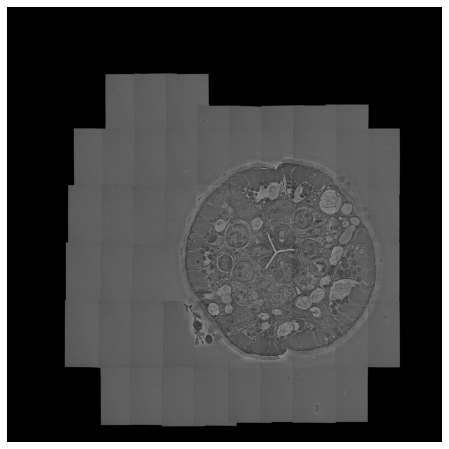

In [22]:
plt.figure(figsize=(8,8))
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.axis("off")
plt.show()

## Transform sample section

In [32]:
def translate_img(img, tr):
    
    x_tr = int(tr[1])
    y_tr = int(tr[0])
    
    (h,w) = img.shape
    
    img_new = np.zeros((img.shape[0],img.shape[1]), dtype="uint8")
    if x_tr>=0 and y_tr>=0:
        img_new[:h-y_tr,:w-x_tr] = img[y_tr:,x_tr:]
    elif x_tr>=0 and y_tr<0:
        img_new[-y_tr:,:w-x_tr] = img[:h+y_tr,x_tr:]
    elif x_tr<0 and y_tr>=0:
        img_new[:h-y_tr,-x_tr:] = img[y_tr:,:w+x_tr]
    else:
        img_new[-y_tr:,-x_tr:] = img[:h+y_tr,:w+x_tr]
        
    return img_new


def get_theta(v1, v2):
    
    s = (v1[0]*v2[1]-v1[1]*v2[0])/np.sum(v1**2)
    c = (v1[0]*v2[0]+v1[1]*v2[1])/np.sum(v1**2)
    
    if s>=0 and c>=0:
        return np.rad2deg(math.asin(s))
    elif s>=0 and c<0:
        return np.rad2deg(math.acos(c))
    elif s<0 and c<0:
        return 360-np.rad2deg(math.acos(c))
    else:
        return 360+np.rad2deg(math.asin(s))
    

def get_vector(ct, cn):
    
    vec = cn - ct
    return vec/np.sum(vec**2)**0.5
    

### CloudVolume volume

In [17]:
vol = CloudVolume("gs://zetta_jkim_001_drop/celegans_montage_unaligned", parallel=True, progress=False)

### Transform

#### Reference landmarks

In [34]:
ref_ct = ct_p[np.where(ct_p[:,2]==344)][0,:2]
ref_cn = cn_p[np.where(cn_p[:,2]==344)][0,:2]
ref_v = get_vector(ref_ct, ref_cn)

In [42]:
z = 340
img = vol[:,:,z].reshape(25000,25000)

img_ct = ct_p[np.where(ct_p[:,2]==z)][0,:2]
img_cn = cn_p[np.where(cn_p[:,2]==z)][0,:2]

img_v = get_vector(img_ct, img_cn)

ref_ct = (12500,12500)
# Translate
tr = img_ct - ref_ct
img_tr = translate_img(img, tr)

# Rotate
theta = get_theta(img_v, ref_v)
img_rot = rotate(img_tr, theta, center=ref_ct)

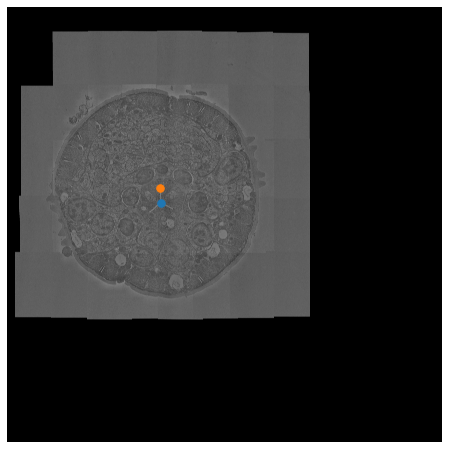

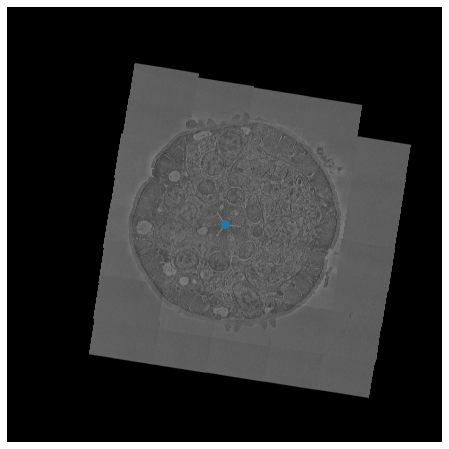

In [43]:
plt.figure(figsize=(8,8))
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.plot(img_ct[1], img_ct[0], '.', markersize=15)
plt.plot(img_cn[1], img_cn[0], '.', markersize=15)
plt.axis("off")
plt.show()

# plt.figure(figsize=(8,8))
# plt.imshow(img_tr, cmap="gray", vmin=0, vmax=255)
# plt.plot(ref_ct[1], ref_ct[0], '.', markersize=15)
# plt.axis("off")
# plt.show()

plt.figure(figsize=(8,8))
plt.imshow(img_rot, cmap="gray", vmin=0, vmax=1)
plt.plot(ref_ct[1], ref_ct[0], '.', markersize=15)
plt.axis("off")
plt.show()

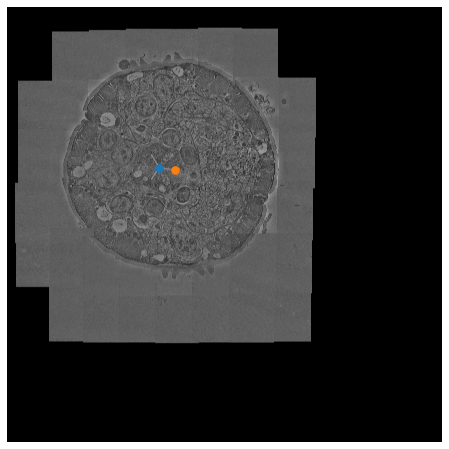

In [64]:
z = 344
img = vol[:,:,z].reshape(25000,25000)

img_ct = ct_p[np.where(ct_p[:,2]==z)][0,:2]
img_cn = cn_p[np.where(cn_p[:,2]==z)][0,:2]

plt.figure(figsize=(8,8))
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.plot(img_ct[1], img_ct[0], '.', markersize=15)
plt.plot(img_cn[1], img_cn[0], '.', markersize=15)
plt.axis("off")
plt.show()

## Transform

In [9]:
cvname = "gs://zetta_jkim_001_n2da_1430/celegans_montage_aligned"

info = CloudVolume.create_new_info(
        num_channels = 1,
        layer_type = 'image', # 'image' or 'segmentation'
        data_type = 'uint8', # can pick any popular uint
        encoding = 'raw', # other option: 'jpeg' but it's lossy
        resolution = [1,1,50], # X,Y,Z values in nanometers
        voxel_offset = [0,0,0], # values X,Y,Z values in voxels
        chunk_size = [256,256,1], # rechunk of image X,Y,Z in voxels
        volume_size = [25000,25000,723], # X,Y,Z size in voxels
    )

vol_out = CloudVolume(cvname, parallel=True, progress=False, cdn_cache=False, info=info)
vol_out.provenance.description = "Rough aligned montaged image"
vol_out.provenance.owners = ["jabae@zetta.ai"]

vol_out.commit_info()
vol_out.commit_provenance()

In [7]:
vol = CloudVolume("gs://zetta_jkim_001_drop/celegans_montage_unaligned", parallel=True, progress=False)

In [ ]:
n = 723

for i in range(n):
    
    img = vol[:,:,i].reshape(25000,25000)

    img_ct = ct_p[np.where(ct_p[:,2]==i)][0,:2]
    img_cn = cn_p[np.where(cn_p[:,2]==i)][0,:2]

    img_v = get_vector(img_ct, img_cn)

    ref_ct = (12500,12500)
    # Translate
    tr = img_ct - ref_ct
    img_tr = translate_img(img, tr)

    # Rotate
    theta = get_theta(img_v, ref_v)
    img_rot = rotate(img_tr, theta, center=ref_ct)
    img_rot = (img_rot*255).astype("uint8")
    
    vol_out[:,:,i] = img_rot.reshape((25000,25000,1))
    print("Section {} done.".format(i))

Section 0 done.
Section 1 done.
Section 2 done.
Section 3 done.
Section 4 done.
Section 5 done.
Section 6 done.
Section 7 done.
Section 8 done.
Section 9 done.
Section 10 done.
Section 11 done.
Section 12 done.
Section 13 done.
Section 14 done.
Section 15 done.
Section 16 done.
Section 17 done.
Section 18 done.
Section 19 done.
Section 20 done.
Section 21 done.
Section 22 done.
Section 23 done.
Section 24 done.
Section 25 done.
Section 26 done.
Section 27 done.
Section 28 done.
Section 29 done.


## Crack masks

In [13]:
d = "/Users/jabae/Downloads/crack"
flist = os.listdir(d)
flist.sort()

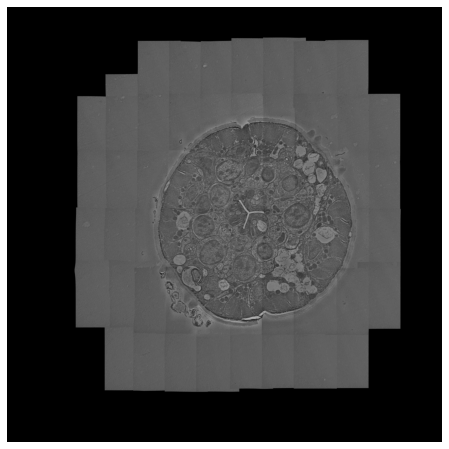

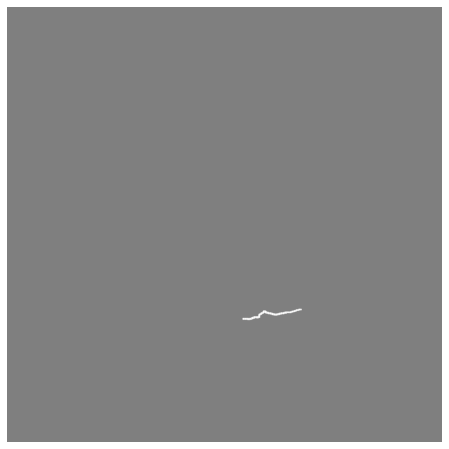

In [23]:
vol = CloudVolume("gs://zetta_jkim_001_drop/celegans_montage_unaligned", mip=4, parallel=True, progress=False)

i = 58
img = vol[:,:,i][:,:,0,0]

plt.figure(figsize=(8,8))
plt.imshow(img, cmap="gray", vmin=0, vmax=255)
plt.axis("off")
plt.show()

mask = tif.imread(os.path.join(d,flist[i]))

plt.figure(figsize=(8,8))
plt.imshow(mask[:,:,0], cmap="gray", vmin=0, vmax=255, alpha=0.5)
plt.axis("off")
plt.show()

In [28]:
cvname = "gs://zetta_jkim_001_n2da_1430/crack_mask"

info = CloudVolume.create_new_info(
        num_channels = 1,
        layer_type = 'image', # 'image' or 'segmentation'
        data_type = 'uint8', # can pick any popular uint
        encoding = 'raw', # other option: 'jpeg' but it's lossy
        resolution = [16,16,50], # X,Y,Z values in nanometers
        voxel_offset = [0,0,0], # values X,Y,Z values in voxels
        chunk_size = [256,256,1], # rechunk of image X,Y,Z in voxels
        volume_size = [1563,1563,723], # X,Y,Z size in voxels
    )

vol_out = CloudVolume(cvname, parallel=True, progress=False, cdn_cache=False, info=info)
vol_out.provenance.description = "Rough aligned crack masks"
vol_out.provenance.owners = ["jabae@zetta.ai"]

vol_out.commit_info()
vol_out.commit_provenance()

In [38]:
cvname = "gs://zetta_jkim_001_n2da_1430/crack_mask"
vol_out = CloudVolume(cvname, parallel=True, progress=False)

n = 723

for i in range(n):
    
    mask = tif.imread(os.path.join(d,flist[i]))
    mask = mask[:,:,0]

    img_ct = ct_p[np.where(ct_p[:,2]==i)][0,:2]
    img_cn = cn_p[np.where(cn_p[:,2]==i)][0,:2]
    img_v = get_vector(img_ct, img_cn)

    img_ct = (img_ct/16).astype("int")
    ref_ct = (int(12500/16),int(12500/16))
    
    # Translate
    tr = img_ct - ref_ct
    mask_tr = translate_img(mask, tr)

    # Rotate
    theta = get_theta(img_v, ref_v)
    mask_rot = rotate(mask_tr, theta, center=ref_ct)
    mask_rot = (mask_rot*255).astype("uint8")
    
    vol_out[:,:,i] = mask_rot.reshape((1563,1563,1))
    print("Section {} done.".format(i))

Section 0 done.
Section 1 done.
Section 2 done.
Section 3 done.
Section 4 done.
Section 5 done.
Section 6 done.
Section 7 done.
Section 8 done.
Section 9 done.
Section 10 done.
Section 11 done.
Section 12 done.
Section 13 done.
Section 14 done.
Section 15 done.
Section 16 done.
Section 17 done.
Section 18 done.
Section 19 done.
Section 20 done.
Section 21 done.
Section 22 done.
Section 23 done.
Section 24 done.
Section 25 done.
Section 26 done.
Section 27 done.
Section 28 done.
Section 29 done.
Section 30 done.
Section 31 done.
Section 32 done.
Section 33 done.
Section 34 done.
Section 35 done.
Section 36 done.
Section 37 done.
Section 38 done.
Section 39 done.
Section 40 done.
Section 41 done.
Section 42 done.
Section 43 done.
Section 44 done.
Section 45 done.
Section 46 done.
Section 47 done.
Section 48 done.
Section 49 done.
Section 50 done.
Section 51 done.
Section 52 done.
Section 53 done.
Section 54 done.
Section 55 done.
Section 56 done.
Section 57 done.
Section 58 done.
Section

Section 462 done.
Section 463 done.
Section 464 done.
Section 465 done.
Section 466 done.
Section 467 done.
Section 468 done.
Section 469 done.
Section 470 done.
Section 471 done.
Section 472 done.
Section 473 done.
Section 474 done.
Section 475 done.
Section 476 done.
Section 477 done.
Section 478 done.
Section 479 done.
Section 480 done.
Section 481 done.
Section 482 done.
Section 483 done.
Section 484 done.
Section 485 done.
Section 486 done.
Section 487 done.
Section 488 done.
Section 489 done.
Section 490 done.
Section 491 done.
Section 492 done.
Section 493 done.
Section 494 done.
Section 495 done.
Section 496 done.
Section 497 done.
Section 498 done.
Section 499 done.
Section 500 done.
Section 501 done.
Section 502 done.
Section 503 done.
Section 504 done.
Section 505 done.
Section 506 done.
Section 507 done.
Section 508 done.
Section 509 done.
Section 510 done.
Section 511 done.
Section 512 done.
Section 513 done.
Section 514 done.
Section 515 done.
Section 516 done.
Section 51

IndexError: list index out of range

## Fold masks 

In [39]:
d = "/Users/jabae/Downloads/fold"
flist = os.listdir(d)
flist.sort()

In [40]:
cvname = "gs://zetta_jkim_001_n2da_1430/fold_mask"

info = CloudVolume.create_new_info(
        num_channels = 1,
        layer_type = 'image', # 'image' or 'segmentation'
        data_type = 'uint8', # can pick any popular uint
        encoding = 'raw', # other option: 'jpeg' but it's lossy
        resolution = [16,16,50], # X,Y,Z values in nanometers
        voxel_offset = [0,0,0], # values X,Y,Z values in voxels
        chunk_size = [256,256,1], # rechunk of image X,Y,Z in voxels
        volume_size = [1563,1563,723], # X,Y,Z size in voxels
    )

vol_out = CloudVolume(cvname, parallel=True, progress=False, cdn_cache=False, info=info)
vol_out.provenance.description = "Rough aligned fold masks"
vol_out.provenance.owners = ["jabae@zetta.ai"]

vol_out.commit_info()
vol_out.commit_provenance()

In [41]:
n = 722

for i in range(n):
    
    mask = tif.imread(os.path.join(d,flist[i]))
    mask = mask[:,:,0]

    img_ct = ct_p[np.where(ct_p[:,2]==i)][0,:2]
    img_cn = cn_p[np.where(cn_p[:,2]==i)][0,:2]
    img_v = get_vector(img_ct, img_cn)

    img_ct = (img_ct/16).astype("int")
    ref_ct = (int(12500/16),int(12500/16))
    
    # Translate
    tr = img_ct - ref_ct
    mask_tr = translate_img(mask, tr)

    # Rotate
    theta = get_theta(img_v, ref_v)
    mask_rot = rotate(mask_tr, theta, center=ref_ct)
    mask_rot = (mask_rot*255).astype("uint8")
    
    vol_out[:,:,i] = mask_rot.reshape((1563,1563,1))
    print("Section {} done.".format(i))

Section 0 done.
Section 1 done.
Section 2 done.
Section 3 done.
Section 4 done.
Section 5 done.
Section 6 done.
Section 7 done.
Section 8 done.
Section 9 done.
Section 10 done.
Section 11 done.
Section 12 done.
Section 13 done.
Section 14 done.
Section 15 done.
Section 16 done.
Section 17 done.
Section 18 done.
Section 19 done.
Section 20 done.
Section 21 done.
Section 22 done.
Section 23 done.
Section 24 done.
Section 25 done.
Section 26 done.
Section 27 done.
Section 28 done.
Section 29 done.
Section 30 done.
Section 31 done.
Section 32 done.
Section 33 done.
Section 34 done.
Section 35 done.
Section 36 done.
Section 37 done.
Section 38 done.
Section 39 done.
Section 40 done.
Section 41 done.
Section 42 done.
Section 43 done.
Section 44 done.
Section 45 done.
Section 46 done.
Section 47 done.
Section 48 done.
Section 49 done.
Section 50 done.
Section 51 done.
Section 52 done.
Section 53 done.
Section 54 done.
Section 55 done.
Section 56 done.
Section 57 done.
Section 58 done.
Section

Section 462 done.
Section 463 done.
Section 464 done.
Section 465 done.
Section 466 done.
Section 467 done.
Section 468 done.
Section 469 done.
Section 470 done.
Section 471 done.
Section 472 done.
Section 473 done.
Section 474 done.
Section 475 done.
Section 476 done.
Section 477 done.
Section 478 done.
Section 479 done.
Section 480 done.
Section 481 done.
Section 482 done.
Section 483 done.
Section 484 done.
Section 485 done.
Section 486 done.
Section 487 done.
Section 488 done.
Section 489 done.
Section 490 done.
Section 491 done.
Section 492 done.
Section 493 done.
Section 494 done.
Section 495 done.
Section 496 done.
Section 497 done.
Section 498 done.
Section 499 done.
Section 500 done.
Section 501 done.
Section 502 done.
Section 503 done.
Section 504 done.
Section 505 done.
Section 506 done.
Section 507 done.
Section 508 done.
Section 509 done.
Section 510 done.
Section 511 done.
Section 512 done.
Section 513 done.
Section 514 done.
Section 515 done.
Section 516 done.
Section 51